# Install MongoDB & Load Data

In [1]:
!apt install mongodb > /dev/null
from pymongo import MongoClient
import pandas as pd

In [2]:
!service mongodb start

 * Starting database mongodb
   ...done.


In [3]:
!wget -q https://raw.githubusercontent.com/UKB95/BDNS/main/PX03_Churn.json

In [4]:
!mongoimport --jsonArray --db PraxisDB --collection PX03_Churn --drop --file PX03_Churn.json

2023-02-01T06:01:38.198+0000	connected to: localhost
2023-02-01T06:01:38.199+0000	dropping: PraxisDB.PX03_Churn
2023-02-01T06:01:38.331+0000	imported 5000 documents


In [5]:
mongoURI = "mongodb://localhost:27017/"    # local
client = MongoClient(mongoURI)
client.list_database_names() 

['PraxisDB', 'admin', 'config', 'local']

In [6]:
db = client.PraxisDB
db.list_collection_names()

['PX03_Churn']

In [8]:
table = db.PX03_Churn
table.count_documents({})

5000

# EDA

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#View whole data as dataframe
df = pd.DataFrame(list(db.PX03_Churn.find()))
df

,_id,phoneno,age,gender,zipcode,calls,sms,mms,charges,coverage,complaint,sim,phone,prepost,churn
0,63da0042333ca48a71064b61,4535,1.0,Male,90089,150.0,45,19,340,0,3,Dual Sim,Andoid,Prepaid,0
1,63da0042333ca48a71064b62,5974,1.0,Male,91107,160.0,25,1,490,0,4,Dual Sim,Andoid,Prepaid,0
2,63da0042333ca48a71064b63,4016,1.0,Male,94720,100.0,39,15,110,0,1,Single Sim,Andoid,Prepaid,0
3,63da0042333ca48a71064b64,8523,2.0,Male,94112,270.0,35,9,1000,0,1,Single Sim,Andoid,Prepaid,0
4,63da0042333ca48a71064b65,5052,2.0,Female,91330,100.0,35,8,450,0,4,Single Sim,Andoid,Prepaid,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,63da0042333ca48a71065ee8,4704,3.0,Male,92697,190.0,29,3,400,0,1,Single Sim,Andoid,Postpaid,0
4996,63da0042333ca48a71065ee9,7402,3.0,Male,93023,30.0,63,39,240,0,2,Single Sim,Andoid,Prepaid,0
4997,63da0042333ca48a71065eea,3149,1.0,Male,92037,40.0,30,4,150,1,4,Single Sim,Andoid,Postpaid,0
4998,63da0042333ca48a71065eeb,5742,2.0,Male,90034,50.0,65,40,490,0,3,Single Sim,Andoid,Postpaid,0


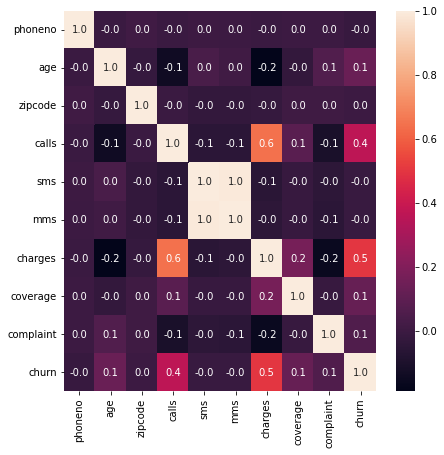

In [11]:
#Correlation Heatmap
plt.figure(figsize=(7,7))
sns.heatmap (df.corr(),annot=True , fmt=".1f")

Charges and Calls are the strong predictors of churn.

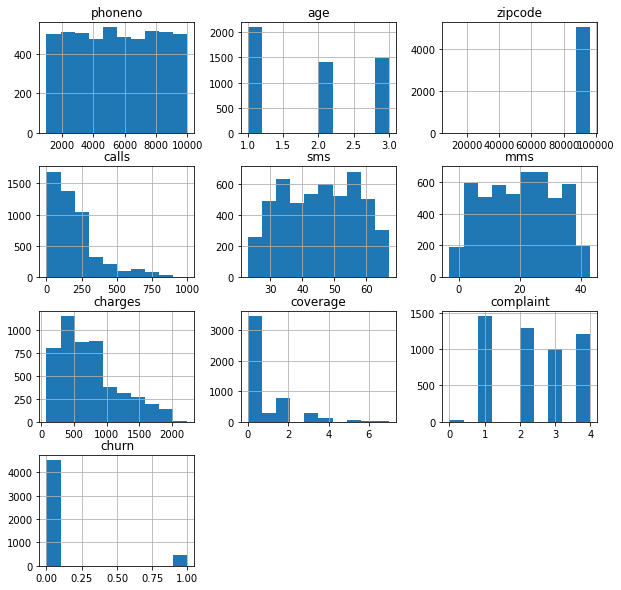

In [12]:
#Histogram of Numerical Variables
plt.rcParams['figure.figsize'] = (10,10)
df.hist()
plt.show()

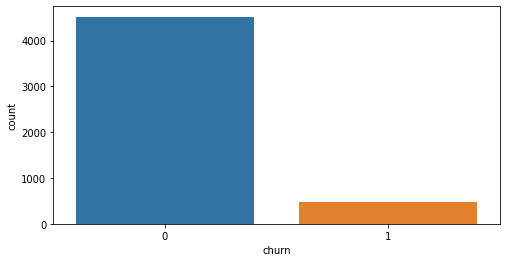

In [13]:
#Count Plot of the Target Variable
plt.rcParams['figure.figsize'] = (8,4)
sns.countplot(x='churn', data = df)

# Install Spark and Transfer Data

In [14]:
!pip3 install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 19.2 MB/s eta 0:00:00


In [15]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

In [16]:
sparkDF = spark.read.format("mongo").option("uri","mongodb://127.0.0.1/PraxisDB.PX03_Churn").load()
sparkDF.show()

+--------------------+----+-----+-------+-----+---------+--------+------+---+------+-------+--------+----------+---+-------+
|                 _id| age|calls|charges|churn|complaint|coverage|gender|mms| phone|phoneno| prepost|       sim|sms|zipcode|
+--------------------+----+-----+-------+-----+---------+--------+------+---+------+-------+--------+----------+---+-------+
|{63da0042333ca48a...|   1|  150|    340|    0|        3|       0|  Male| 19|Andoid|   4535| Prepaid|  Dual Sim| 45|  90089|
|{63da0042333ca48a...|   1|  160|    490|    0|        4|       0|  Male|  1|Andoid|   5974| Prepaid|  Dual Sim| 25|  91107|
|{63da0042333ca48a...|   1|  100|    110|    0|        1|       0|  Male| 15|Andoid|   4016| Prepaid|Single Sim| 39|  94720|
|{63da0042333ca48a...|   2|  270|   1000|    0|        1|       0|  Male|  9|Andoid|   8523| Prepaid|Single Sim| 35|  94112|
|{63da0042333ca48a...|   2|  100|    450|    0|        4|       0|Female|  8|Andoid|   5052| Prepaid|Single Sim| 35|  91330|


In [17]:
sparkDF = sparkDF.drop("_id")
sparkDF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- calls: integer (nullable = true)
 |-- charges: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- complaint: integer (nullable = true)
 |-- coverage: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- mms: integer (nullable = true)
 |-- phone: string (nullable = true)
 |-- phoneno: integer (nullable = true)
 |-- prepost: string (nullable = true)
 |-- sim: string (nullable = true)
 |-- sms: integer (nullable = true)
 |-- zipcode: integer (nullable = true)



In [18]:
print((sparkDF.count(), len(sparkDF.columns)))

(5000, 14)


# Data Preprocessing

In [19]:
sparkDF.toPandas().isnull().sum()

age          6
calls        6
charges      0
churn        0
complaint    0
coverage     0
gender       0
mms          0
phone        0
phoneno      0
prepost      0
sim          0
sms          0
zipcode      0
dtype: int64

In [20]:
sparkDF.describe().show()

+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+------+------------------+------+-----------------+--------+----------+------------------+-----------------+
|summary|               age|             calls|          charges|              churn|         complaint|          coverage|gender|               mms| phone|          phoneno| prepost|       sim|               sms|          zipcode|
+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+------+------------------+------+-----------------+--------+----------+------------------+-----------------+
|  count|              4994|              4994|             5000|               5000|              5000|              5000|  5000|              5000|  5000|             5000|    5000|      5000|              5000|             5000|
|   mean|1.8804565478574289|193.82238686423707|          737.742|       

In [21]:
sparkDF = sparkDF.na.fill(value=1.88,subset=["age"])
sparkDF = sparkDF.na.fill(value=193.82,subset=["calls"])

In [22]:
sparkDF.toPandas().isnull().sum()

age          0
calls        0
charges      0
churn        0
complaint    0
coverage     0
gender       0
mms          0
phone        0
phoneno      0
prepost      0
sim          0
sms          0
zipcode      0
dtype: int64

# Feature Engineering

In [23]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [24]:
gender_indexer = StringIndexer(inputCol='gender',outputCol='gender_num')
phone_indexer = StringIndexer(inputCol='phone',outputCol='phone_num')
prepost_indexer = StringIndexer(inputCol='prepost',outputCol='prepost_num')
sim_indexer = StringIndexer(inputCol='sim',outputCol='sim_num')
encoder = OneHotEncoder(inputCols=["gender_num","phone_num","prepost_num","sim_num"],
                       outputCols=["gender_vector","phone_vector","prepost_vector","sim_vector"])

In [25]:
assembler=VectorAssembler(inputCols=['age', 'calls', 'charges', 'complaint', 'coverage', 'gender_vector',
                                     'mms', 'phone_vector', 'prepost_vector', 'sim_vector',
                                     'sms'],outputCol='features')
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [27]:
basepipe = Pipeline(stages=[gender_indexer, phone_indexer, prepost_indexer, sim_indexer,
                            encoder, assembler, standard_scaler])

In [30]:
basepipe.fit(sparkDF).transform(sparkDF).select(['features_scaled','churn']).show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features_scaled                                                                                                                                                                    |churn|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[1.190647713352673,0.8585249487364706,0.7385888673682994,2.599516341396305,0.0,2.194727222433511,1.656790786596853,4.1972669618924305,0.0,0.0,3.925617185544388]                   |0    |
|[1.190647713352673,0.9157599453189019,1.064436897089608,3.4660217885284066,0.0,2.194727222433511,0.08719951508404489,4.1972669618924305,0.0,0.0,2.180898436413549]                 |0    |
|[1.190647713352673,0.5723499658243137,0.23895522179562628,0

# Spark ML Pipelines 

In [31]:
dfTrain, dfTest = sparkDF.randomSplit([0.75,0.25])
print(dfTrain.count(), dfTest.count())

3733 1267


In [32]:
dfTrain.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  355|
|    0| 3378|
+-----+-----+



In [33]:
dfTest.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  125|
|    0| 1142|
+-----+-----+



In [34]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Logistic Regression Pipeline 

In [35]:
logreg = LogisticRegression(labelCol='churn',featuresCol='features_scaled',maxIter=5)
logreg_pipeline = Pipeline(stages=[basepipe,logreg])
logreg_model = logreg_pipeline.fit(dfTrain)
logreg_predictions=logreg_model.transform(dfTest)

In [36]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
evaluator = BinaryClassificationEvaluator(labelCol='churn')

In [37]:
logreg_acc=acc_evaluator.evaluate(logreg_predictions)
print(round(logreg_acc*100,2), 'is the accuracy of the Logistic Regression Pipeline')
logreg_auroc = evaluator.evaluate(logreg_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(logreg_auroc))

94.71 is the accuracy of the Logistic Regression Pipeline
Area under ROC Curve: 0.9543


## Random Forest Pipeline

In [38]:
from pyspark.ml.classification import RandomForestClassifier

In [40]:
ranfor = RandomForestClassifier(featuresCol='features_scaled', labelCol='churn')
ranfor_pipeline = Pipeline(stages=[basepipe, ranfor])
ranfor_model = ranfor_pipeline.fit(dfTrain)
ranfor_predictions=ranfor_model.transform(dfTest)

In [41]:
ranfor_acc=acc_evaluator.evaluate(ranfor_predictions)
print(round(ranfor_acc*100,2), 'is the accuracy of the Random Forest Pipeline')
ranfor_auroc = evaluator.evaluate(ranfor_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(ranfor_auroc))

97.95 is the accuracy of the Random Forest Pipeline
Area under ROC Curve: 0.9975


## Gradient Boost Pipeline

In [42]:
from pyspark.ml.classification import GBTClassifier

In [43]:
gbt = GBTClassifier(featuresCol='features_scaled', labelCol='churn')
gbt_pipeline = Pipeline(stages=[basepipe, gbt])
gbt_model = gbt_pipeline.fit(dfTrain)
gbt_predictions=gbt_model.transform(dfTest)

In [44]:
gbt_acc=acc_evaluator.evaluate(gbt_predictions)
print(round(gbt_acc*100,2), 'is the accuracy of the Gradient Boost Pipeline')
gbt_auroc = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(gbt_auroc))

98.74 is the accuracy of the Gradient Boost Pipeline
Area under ROC Curve: 0.9978


# Comparison of the Models

In [45]:
print(round(logreg_acc*100,2), 'is the accuracy of the Logistic Regression Pipeline')
print(round(ranfor_acc*100,2), 'is the accuracy of the Random Forest Pipeline')
print(round(gbt_acc*100,2), 'is the accuracy of the Gradient Boost Pipeline')

94.71 is the accuracy of the Logistic Regression Pipeline
97.95 is the accuracy of the Random Forest Pipeline
98.74 is the accuracy of the Gradient Boost Pipeline


In [46]:
print("Area under ROC Curve for Logistic Regression : {:.4f}".format(logreg_auroc))
print("Area under ROC Curve for Random Forest       : {:.4f}".format(ranfor_auroc))
print("Area under ROC Curve for Gradient Boost      : {:.4f}".format(gbt_auroc))

Area under ROC Curve for Logistic Regression : 0.9543
Area under ROC Curve for Random Forest       : 0.9975
Area under ROC Curve for Gradient Boost      : 0.9978


*Gradient Boost gives us the best result as compared to other ML models. Hence, it can be used to predict future churn.*